# The Follow the Directed - Lab

In this assignment we see what follows when one follows directions, in exploration. We see what happens when exploration is not totally random, but is directed by an information bonus of some kind. The two kinds are the, no surprise, the UCB, and a new idea for us, novetly. We will be comparing to a softmax explorer, with the aid bonus, and the bounded sequential (pure) explorer. 

Recall one of the readings this week:

> 

Ng's point, or reallt the impact of his work on us, even if he never made the point directly, is that common bonuses used in directed exploration schemes for humans and agents can introduce a statistical biass to the ability to accuratly measure the value of actions?

AKA Does inductive bias imply statistical bias? Here, anyway. (_Note_: This is not true in general, or for all systems. It _is_ sometimes true, and it is very important to know when.) 

The reward value $Q$ update rule for all agents (below):

$$ Q \leftarrow Q + \alpha * (\hat R - Q) $$

where $\hat R = R + \lambda I$ and $I$ is a standin for the information bonus. The equation for UCB follows. In it $t$ is the number of steps in an episode, and $N_a$ is the number of times that action has been taken. 

$$\sqrt{log(t)/ N_a)}$$ 

If an action hasn't been tried very often, or not at all, the $N_a$ will be small and the uncertienty which UCB reflects will be large, or relatvily large anyway. The larger the UCB is, when it is treated as an intrinsic reward, the morer likely that action will be accepts.

There is not real reason to write an equation for the novely bonus. It works like this. If this is the rirt time taking that action, add a $\lambda$ to the rerward $R$, in the update rule above. Otherwise, do noting. THis one time bonus littera vale everywhere, making it livkely all the actions will explored, at least a little. 

(_Pssssst_ - there is good evidence that such novely signals exist in bothhuman, monkey, and mouse brains).

The action policy, aka the _Actor_, will use the softmax sampling policy, whose frree parameter $\beta$ controls how soft the softmax is. Larger values make it harder. Aka, morre like a pure max.

The questions to answer this week are: 

1. Does good bias cause bad bias in two common directed schemes? If so, how much?
2. Does this bad bias even matter? Or really, can it matter in simple example that looks common enough in the real world?

The setting is a four-bandit. Our last time with these robbers.[**] The lab has two sections.

_First_ we get to know our new agents, comparing rewards to value error. Doing some tuning.

_Second_ we tet how much this matters by testing how well out agents recover then the best choice "runs out" of rewards, then changes to becomes the worst choice.

In this lab we use two metrics. The familiar _total reward_, and a new error (RMSE) that measures the difference between the true expected value of each action, to the values that were learned by each agent.

In [ ]:
# Install explorationlib?
!pip install --upgrade git+https://github.com/parenthetical-e/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

In [120]:
# Import 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Env
import explorationlib
from explorationlib.local_gym import BanditUniform4
from explorationlib.local_gym import BanditChange4

# Actors and critics
from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic
from explorationlib.agent import CriticUCB
from explorationlib.agent import CriticNovelty
from explorationlib.agent import SoftmaxActor
from explorationlib.agent import DeterministicActor
from explorationlib.agent import BoundedSequentialActor

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Metrics of interest
from explorationlib.score import total_reward
from explorationlib.score import bandit_rmse
from explorationlib.score import action_entropy

# Vis
from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

## Section 1 - The Directed
### Soft explorations
The bigger $\beta$ in softmax exploration, the more greedy or exploitative, the agent will be. To build some intuition, let's look at some examples. Note: there is no bonus here. 

Our bandit for this demo is:

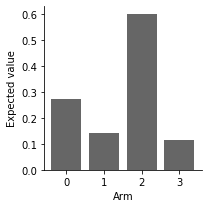

In [5]:
# Env
seed_value = 60
env = BanditUniform4()
env.seed(seed_value)

# -
ax = plot_bandit(env, alpha=0.6)

Let's plot example behavoir for three experiments, at some different levels of $\beta$ (Don't stray from these, at least in the questions; play all you want of course).

In [52]:
num_experiments = 3
num_steps = 4 * 60  # 60 steps / arm; a lot

betas = [2, 4, 6, 8]  
results = []
for beta in betas:
    # (SoftmaxActor is our general reference)
    ref = BanditActorCritic(
        SoftmaxActor(num_actions=env.num_arms, beta=beta),
        Critic(num_inputs=env.num_arms)
    )
    # !
    log = experiment(
        f"demo_{beta}",
        ref,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

demo_8: 100%|██████████| 3/3 [00:00<00:00, 16.38it/s]


Visualize the effect of beta, one experiment per cell (three cell). Look over them all, please.

#### Experiment 0

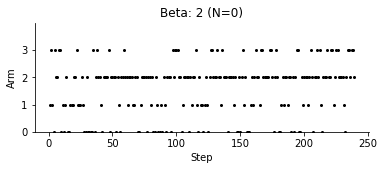

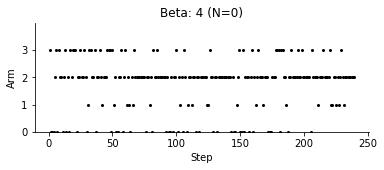

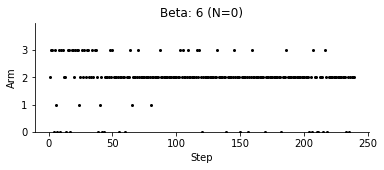

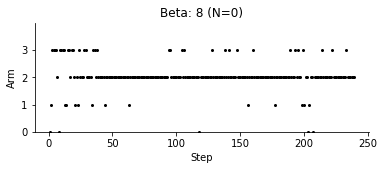

In [53]:
num_experiment = 0
for name, res in zip(betas, results):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        max_steps=num_steps,
        s=4,
        title=f"Beta: {name} (N={num_experiment})", 
        color="black",
        figsize=(6,2)
    )

#### Experiment 1

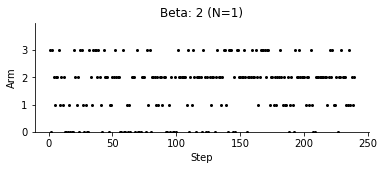

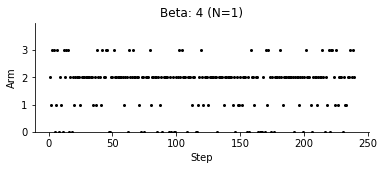

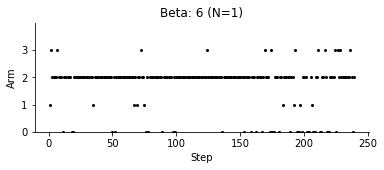

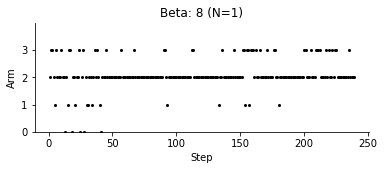

In [54]:
num_experiment = 1
for name, res in zip(betas, results):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        max_steps=num_steps,
        s=4,
        title=f"Beta: {name} (N={num_experiment})", 
        color="black",
        figsize=(6,2)
    )

#### Experiment 2

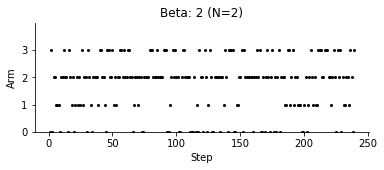

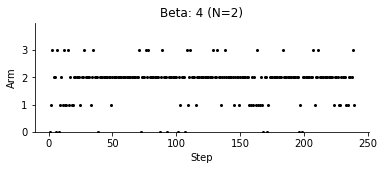

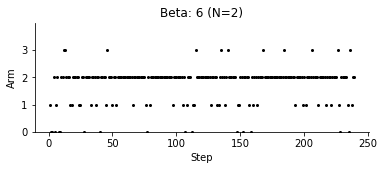

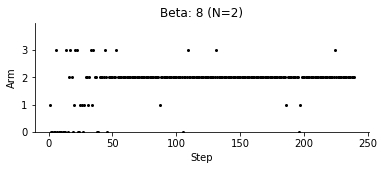

In [55]:
num_experiment = 2
for name, res in zip(betas, results):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        max_steps=num_steps,
        s=4,
        title=f"Beta: {name} (N={num_experiment})", 
        color="black",
        figsize=(6,2)
    )

#### Question 1.1
In the paper below, the authors offered evidence that people tune their use of information bonuses, and their level of noise, depending on the task, the information available, and the horizon for exploration they have to work with. So...

To prove the point, let's do the opposite. Running no more simulaations, and knowing nothing about how much reward the above returned, make a best guess for the $\beta$ value you believe can be a fair and robust choice for the entire lab to come. Keep in mind the brief desscription I gave you of Section 2, and the exploration bonuses will be in play soon.

_Hint_: Arm 2 is the most valauble choice. It is the "best" arm.

_Warning_: Don't cheat. Make a guess. Explain why. And you'll do fine grading wise

In [56]:
# Write your answer below as a code cell. Explain your choice here as a comment.

In [78]:
beta = 4.0 # change me? (My choice of 1.0 is not a hint. I picked it at random.

Let's compare performance between the reference _SoftmaxActor_ using a plain old _Critic_, and a critic using UCB bonuses _CriticUCB_ and a _CriticNovelty_ bonus agent?

#### Question 1.2
Make a guess, will adding a bonus increase of decrease the total rewards collected compared to the raw critic?

In [58]:
# Write your answer here as comment. Explain yourself.

#### Question 1.3
Make a guess, will _CriticUCB_ or _CriticNovelty_ do better?

Hint: _CriticUCB_ provides a running bonus of how uncertian we may be about each arm. _CriticNovelty_ is a one-off bonus at the start. Before answering, consider how much of a hint an agent may need on this task, and how much noise you are using (how small your beta is)? 

Consider the factors in the hint in explaining your answer?

In [59]:
# Write your answer here as comment. Explain yourself.

Well, let's see what happens....

In [60]:
num_experiments = 100
bonus_weight = 0.5

# Agents
ref = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    Critic(num_inputs=env.num_arms)
)
# UCB
ucb = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticUCB(num_inputs=env.num_arms, bonus_weight=bonus_weight)
)
# Novely
nov = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticNovelty(
        num_inputs=env.num_arms, 
        novelty_bonus=1.0,
        bonus_weight=bonus_weight
    )
)

# -
agents = [ref, ucb, nov]
names = ["softmax", "softmax-ucb", "softmax-nov"]
colors = ["blue", "green", "purple"]

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

softmax-nov: 100%|██████████| 100/100 [00:05<00:00, 17.58it/s]


#### Example behave

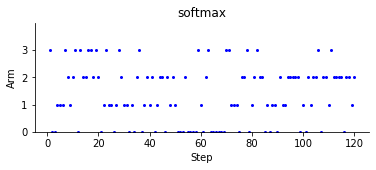

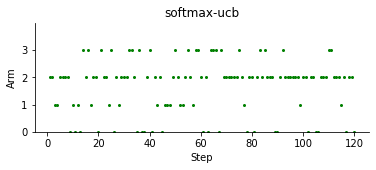

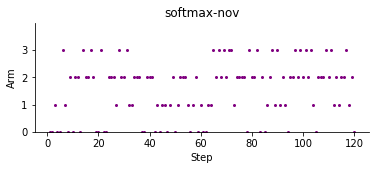

In [50]:
num_experiment = 10
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        max_steps=120,
        s=4,
        title=name, 
        color=color,
        figsize=(6,2)
    )

#### Value

total_reward: 100%|██████████| 100/100 [00:00<00:00, 11515.54it/s]


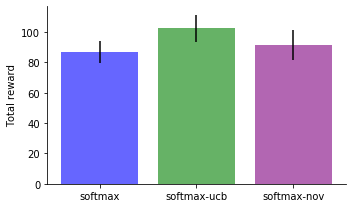

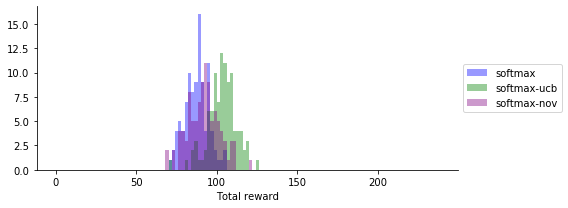

In [51]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(8, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.4, bins=list(range(0, num_steps, 2)))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Total reward")
    plt.tight_layout()
    sns.despine()

#### Question 1.4
Which of the agents in Q1.3 will have the most entropy, and how will this relate the distribution of _total reward_ we plotted in that question?

In [62]:
# Write your answer here as comment. Explain yourself.

Let's see!

action_entropy: 100%|██████████| 100/100 [00:00<00:00, 2430.24it/s]


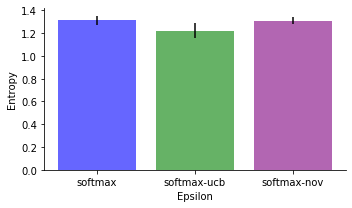

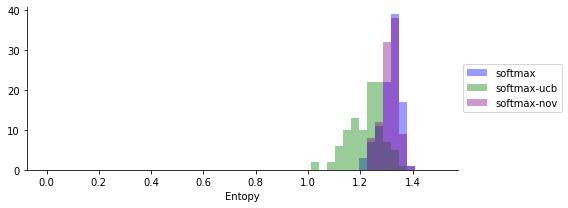

In [72]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = action_entropy(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Entropy")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(8, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.4, bins=np.linspace(0, 1.5, 50))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Entopy")
    plt.tight_layout()
    sns.despine()

#### Question 1.5
Given we are holding noise ($\beta$) constant, is it fair or unfair to consider entropy here to be a direct measure the "directedness" of the exploration? 

In [73]:
# Write your answer here as comment. Explain yourself.

Let's increase the purity of our experiments. Let's add in the _BoundedSequentialActor_ with a normal _Critic_. I'll pick a ambitious _bound_ for us. No need to tune it. Assume I did a good and fair job in my choise


#### Question 1.6
Will _BoundedSequentialActor_ do better or worse than all the other intelligent direct agents we have been playing with? Make a guess, based on the results from the _Be Best_ lab.

In [84]:
# Write your answer here as comment. Explain yourself.

Let's find out....

In [93]:
bonus_weight = 0.5

# Agents
ref = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    Critic(num_inputs=env.num_arms)
)
# UCB
ucb = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticUCB(num_inputs=env.num_arms, bonus_weight=bonus_weight)
)
# Novely
nov = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticNovelty(
        num_inputs=env.num_arms, 
        novelty_bonus=1.0,
        bonus_weight=bonus_weight
    )
)
seq = BanditActorCritic(
    BoundedSequentialActor(num_actions=env.num_arms, bound=20),
    Critic(num_inputs=env.num_arms)
)

# -
agents = [ref, ucb, nov, seq]
names = ["softmax", "softmax-ucb", "softmax-nov", "b-sequential"]
colors = ["blue", "green", "purple", "grey"]

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-sequential: 100%|██████████| 100/100 [00:01<00:00, 78.94it/s]


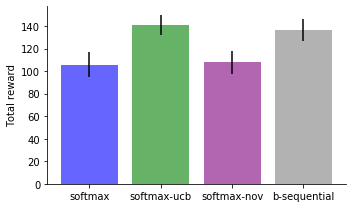

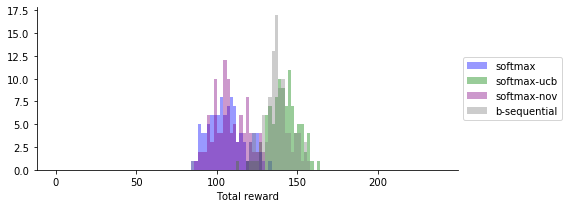

In [89]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(8, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.4, bins=list(range(0, num_steps, 2)))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Total reward")
    plt.tight_layout()
    sns.despine()

#### Question 1.7
Given the results in Q1.6, when we plot entropy below do you think you should revise your prediction for how entropy and total rewards relate? If you do revise it, explain.

In [85]:
# Write your answer here as comment. Explain yourself.

Let's find out....

action_entropy: 100%|██████████| 100/100 [00:00<00:00, 4275.71it/s]


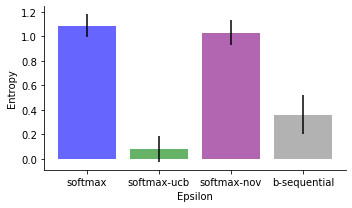

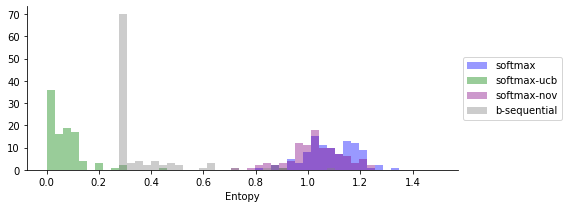

In [90]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = action_entropy(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Entropy")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(8, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.4, bins=np.linspace(0, 1.5, 50))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Entopy")
    plt.tight_layout()
    sns.despine()

#### Question 1.8
Were you right? If not, please try and explain why. Also, was the entropy of the _BoundedSequentialActor_ more or less than you expected? Do you understand why?

In [91]:
# Write your answer here as comment. Explain yourself.

Let's measure the error for the values we learned in Q1.7. 

#### Question 1.9
Rank the models you expect to have the most error, to the least error. If you think one, or more, models will be about the same, that is ok.

One answer to this question could be _BoundedSequentialActor_ > _Critic_ = _CriticUCB_ = _CriticNovelty_, but this is not the right answer. Just helping you with the form I want the answer to take.

In [106]:
# Write your answer here as comment. Explain yourself.

#### Question 1.10
Beyond a simple ranking, how do think the difference in error between the ideal answer and observed answer will relate to the differences in total reward, which often are not that large in these kinds of simple bandit experiments. 

Will the change in error be about linear with total reward, or a lot more, or a lot less?

In [108]:
# Write your answer here as comment. Explain yourself.

Let's find out, by measure the RMSE between the bandits true value and what each agent believes about it

bandit_rmse: 100%|██████████| 100/100 [00:00<00:00, 18650.47it/s]


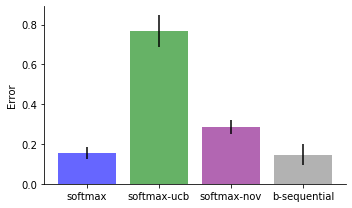

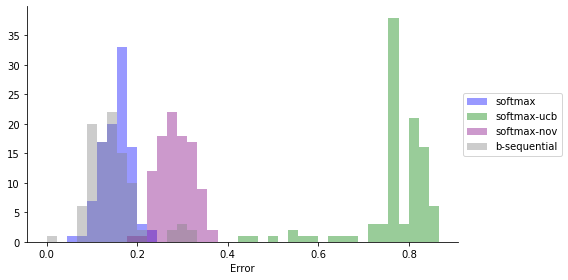

In [109]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = bandit_rmse(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Error")
plt.tight_layout()
sns.despine()

# Dists
bins = np.linspace(0, np.max(scores), 40)
fig = plt.figure(figsize=(8, 4))
for (name, s, c) in zip(names, scores, colors):    
    plt.hist(s, label=name, color=c, alpha=0.4, bins=bins)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Error")
    plt.tight_layout()
    sns.despine()

#### Question 1.11
Does your answer to Q1.10 look about right? If your guess was off, please try an explain why.

In [110]:
# Write your answer here as comment. Explain yourself.

Let's make one big change! Let's change the horison from 240 steps, to 60, and see how thaat change total rewaard, and error.

#### Question 1.12
Do you think a change to horizon will effect the ranking of the models? Why or why not?

In [112]:
# Write your answer here as comment. Explain yourself.

In [113]:
num_steps = 60
bonus_weight = 0.5

# Agents
ref = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    Critic(num_inputs=env.num_arms)
)
# UCB
ucb = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticUCB(num_inputs=env.num_arms, bonus_weight=bonus_weight)
)
# Novely
nov = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticNovelty(
        num_inputs=env.num_arms, 
        novelty_bonus=1.0,
        bonus_weight=bonus_weight
    )
)
seq = BanditActorCritic(
    BoundedSequentialActor(num_actions=env.num_arms, bound=20),
    Critic(num_inputs=env.num_arms)
)

# -
agents = [ref, ucb, nov, seq]
names = ["softmax", "softmax-ucb", "softmax-nov", "b-sequential"]
colors = ["blue", "green", "purple", "grey"]

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-sequential: 100%|██████████| 100/100 [00:00<00:00, 127.58it/s]


total_reward: 100%|██████████| 100/100 [00:00<00:00, 22696.45it/s]


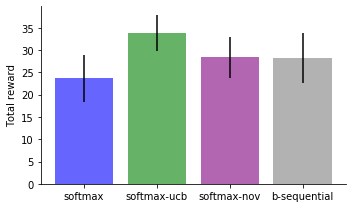

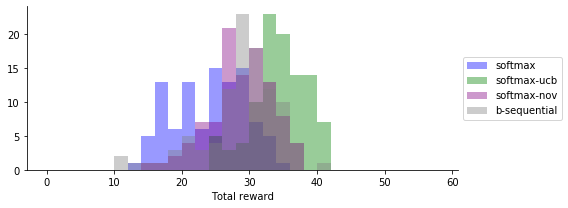

In [114]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(8, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.4, bins=list(range(0, num_steps, 2)))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Total reward")
    plt.tight_layout()
    sns.despine()

bandit_rmse: 100%|██████████| 100/100 [00:00<00:00, 15135.33it/s]


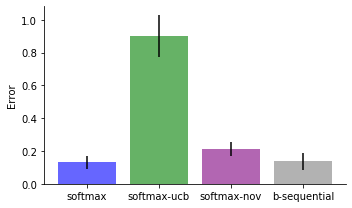

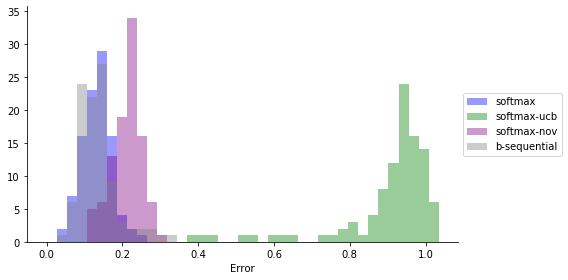

In [115]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = bandit_rmse(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Error")
plt.tight_layout()
sns.despine()

# Dists
bins = np.linspace(0, np.max(scores), 40)
fig = plt.figure(figsize=(8, 4))
for (name, s, c) in zip(names, scores, colors):    
    plt.hist(s, label=name, color=c, alpha=0.4, bins=bins)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Error")
    plt.tight_layout()
    sns.despine()

#### Question 1.14
Was your answer to Q1.13 correct? Why or why not?

In [117]:
# Write your answer here as comment. Explain yourself.

## Section 2 - the world changes
### Can we recover when the best rewards run out?

In this section our task will start off the same as in Section 1. After 60 steps however, the best arm (arm 2) will become the worst. The question is who can recover? And does that recovery matter if they did a really good job collecting reward before the changes

#### Question 2.1
Keeping in mind the change to come, which agent will do the best overall? 

To answer first imagine we run 80 steps in total, 20 steps past the change. The imagine we run 120 steps in total. The in the third part of your answer imagine we run 240 steps (this is the amount we have been using so far. It is 180 steps past the change point, when the best reward runs out).

In [118]:
# Write your answer here as comment. Explain yourself.

Let's find out. Not the values below of the Env before and after then change....

In [124]:
# Experiment settings
# For all keep the maze the saame
num_experiments = 100
num_change = 60
seed_value = 60

# Env
env = BanditChange4(num_change=num_change)
env.seed(seed_value)

[60]

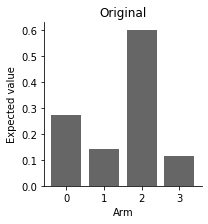

In [122]:
plot_bandit(env.orginal, alpha=0.6, title="Original")

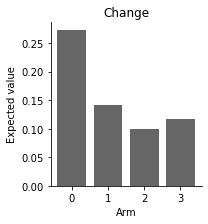

In [123]:
plot_bandit(env.change, alpha=0.6, title="Change")

#### 80 steps

In [136]:
num_steps = 80
bonus_weight = 0.5

# Agents
ref = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    Critic(num_inputs=env.num_arms)
)
# UCB
ucb = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticUCB(num_inputs=env.num_arms, bonus_weight=bonus_weight)
)
# Novely
nov = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticNovelty(
        num_inputs=env.num_arms, 
        novelty_bonus=1.0,
        bonus_weight=bonus_weight
    )
)
seq = BanditActorCritic(
    BoundedSequentialActor(num_actions=env.num_arms, bound=20),
    Critic(num_inputs=env.num_arms)
)

# -
agents = [ref, ucb, nov, seq]
names = ["softmax", "softmax-ucb", "softmax-nov", "b-sequential"]
colors = ["blue", "green", "purple", "grey"]

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-sequential: 100%|██████████| 100/100 [00:00<00:00, 153.85it/s]


total_reward: 100%|██████████| 100/100 [00:00<00:00, 39509.27it/s]


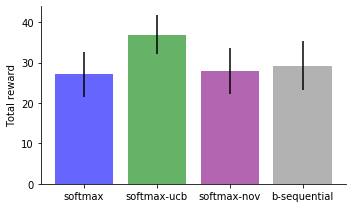

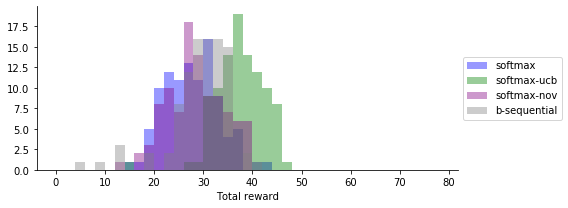

In [134]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(8, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.4, bins=list(range(0, num_steps, 2)))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Total reward")
    plt.tight_layout()
    sns.despine()

#### 120 steps

In [137]:
num_steps = 120
bonus_weight = 0.5

# Agents
ref = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    Critic(num_inputs=env.num_arms)
)
# UCB
ucb = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticUCB(num_inputs=env.num_arms, bonus_weight=bonus_weight)
)
# Novely
nov = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticNovelty(
        num_inputs=env.num_arms, 
        novelty_bonus=1.0,
        bonus_weight=bonus_weight
    )
)
seq = BanditActorCritic(
    BoundedSequentialActor(num_actions=env.num_arms, bound=20),
    Critic(num_inputs=env.num_arms)
)

# -
agents = [ref, ucb, nov, seq]
names = ["softmax", "softmax-ucb", "softmax-nov", "b-sequential"]
colors = ["blue", "green", "purple", "grey"]

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-sequential: 100%|██████████| 100/100 [00:01<00:00, 83.88it/s]


total_reward: 100%|██████████| 100/100 [00:00<00:00, 11697.31it/s]


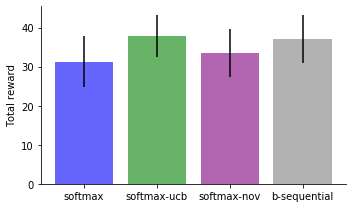

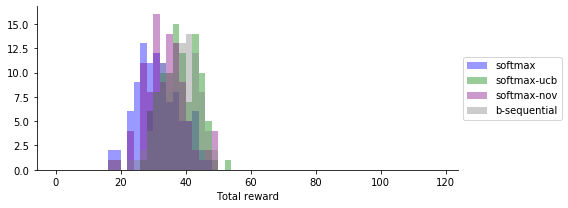

In [138]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(8, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.4, bins=list(range(0, num_steps, 2)))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Total reward")
    plt.tight_layout()
    sns.despine()

#### 240 steps

In [140]:
num_steps = 240
bonus_weight = 0.5

# Agents
ref = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    Critic(num_inputs=env.num_arms)
)
# UCB
ucb = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticUCB(num_inputs=env.num_arms, bonus_weight=bonus_weight)
)
# Novely
nov = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticNovelty(
        num_inputs=env.num_arms, 
        novelty_bonus=1.0,
        bonus_weight=bonus_weight
    )
)
seq = BanditActorCritic(
    BoundedSequentialActor(num_actions=env.num_arms, bound=20),
    Critic(num_inputs=env.num_arms)
)

# -
agents = [ref, ucb, nov, seq]
names = ["softmax", "softmax-ucb", "softmax-nov", "b-sequential"]
colors = ["blue", "green", "purple", "grey"]

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-sequential: 100%|██████████| 100/100 [00:01<00:00, 77.27it/s]


total_reward: 100%|██████████| 100/100 [00:00<00:00, 9292.59it/s]


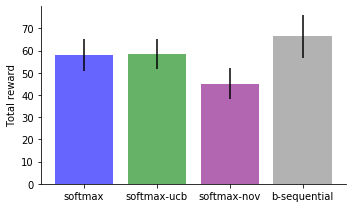

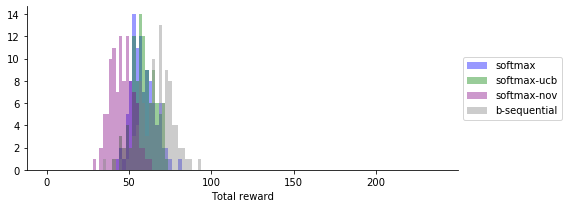

In [142]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(8, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.4, bins=list(range(0, num_steps, 2)))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Total reward")
    plt.tight_layout()
    sns.despine()

This lab has I hope shown you that directed exploration can improve total rewards collected, but at the cost of sometimes large error, and the sometimes this error can limit performance on long horizons when the world changes.

#### Question 2.2
Imagine in our final question that you, intelligent agent you are, could pick and choose among these four agents to be your strategies but in an adaptive way and as you see fit.

Please write down for a situation in which each of the agents might be the best choice. These examples could be in bandit task, in a cliff world, or in an open field. Integrate the enviroments, in other words.

In [143]:
# Write your answer here as comment. Explain yourself.